In [2]:
!pip install prophet

In [3]:
#import dependencies
import pandas as pd
import datetime as dt
from prophet import Prophet
import matplotlib.pyplot as plt

In [4]:
# upload US-Monthly-GDP-History-Data.csv
from google.colab import files
uploaded = files.upload()

Saving US-Monthly-GDP-History-Data.csv to US-Monthly-GDP-History-Data.csv


In [5]:
# read in csv
df= pd.read_csv('US-Monthly-GDP-History-Data.csv')
df

,Unnamed: 0,Monthly Nominal GDP Index,Monthly Real GDP Index,Unnamed: 3,Unnamed: 4
0,1992 - Jan,6315.718,10177.808,NaN,NaN
1,1992 - Feb,6356.508,10222.919,NaN,NaN
2,1992 - Mar,6417.080,10307.964,NaN,NaN
3,1992 - Apr,6443.260,10314.310,NaN,NaN
4,1992 - May,6433.800,10293.473,NaN,NaN
...,...,...,...,...,...
398,NaN,NaN,NaN,NaN,NaN
399,NaN,NaN,NaN,NaN,NaN
400,NaN,NaN,NaN,NaN,NaN
401,NaN,NaN,NaN,NaN,NaN


In [6]:
# rename date column to 'Date'
# use .info() to learn more about the dataframe
df = df.rename(columns= {'Unnamed: 0': 'Date'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       391 non-null    object 
 1   Monthly Nominal GDP Index  391 non-null    float64
 2   Monthly Real GDP Index     391 non-null    float64
 3   Unnamed: 3                 0 non-null      float64
 4   Unnamed: 4                 0 non-null      float64
dtypes: float64(4), object(1)
memory usage: 15.9+ KB


In [7]:
# drop empty columns and rows
df = df[['Date', 'Monthly Nominal GDP Index', 'Monthly Real GDP Index']]
df = df.dropna()
display(df.head())
display(df.tail(10))

,Date,Monthly Nominal GDP Index,Monthly Real GDP Index
0,1992 - Jan,6315.718,10177.808
1,1992 - Feb,6356.508,10222.919
2,1992 - Mar,6417.080,10307.964
3,1992 - Apr,6443.260,10314.310
4,1992 - May,6433.800,10293.473


,Date,Monthly Nominal GDP Index,Monthly Real GDP Index
381,2023 - Oct,27757.209,22524.995
382,2023 - Nov,27936.313,22674.040
383,2023 - Dec,28177.472,22844.025
384,2024 - Jan,28072.857,22684.233
385,2024 - Feb,28360.395,22829.790
386,2024 - Mar,28374.270,22767.625
387,2024 - Apr,28553.963,22853.520
388,2024 - May,28687.910,22960.986
389,2024 - June,28717.658,22967.554
390,2024 - July,28909.887,23069.876


In [8]:
# create a dict and store the month abbrev. with their corresponding number
months= {'Jan': "01", 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05',
        'Jun': '06', 'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10',
         'Nov': '11', 'Dec': '12'}
# for each month abbrev. in 'Date' column, replace it with corresponding number

df['Date'] = df['Date'].replace(months, regex=True)

In [9]:
# convert to date to datetime
# set index to 'Date'
# take years only up until 2015

try:
    df['Date'] = pd.to_datetime(df['Date'], errors = 'coerce')
except Exception as e:
    print(e)

df = df.dropna(subset=['Date'])
gdp_df= df.set_index('Date')

gdp_df = gdp_df.loc['1992':'2015']
gdp_df

<ipython-input-9-1a1a534dc617>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors = 'coerce')


,Monthly Nominal GDP Index,Monthly Real GDP Index
Date,,
1992-01-01,6315.718,10177.808
1992-02-01,6356.508,10222.919
1992-03-01,6417.080,10307.964
1992-04-01,6443.260,10314.310
1992-05-01,6433.800,10293.473
...,...,...
2015-08-01,18379.862,18831.586
2015-09-01,18456.886,18920.520
2015-10-01,18469.416,18917.436


<Axes: xlabel='Date'>

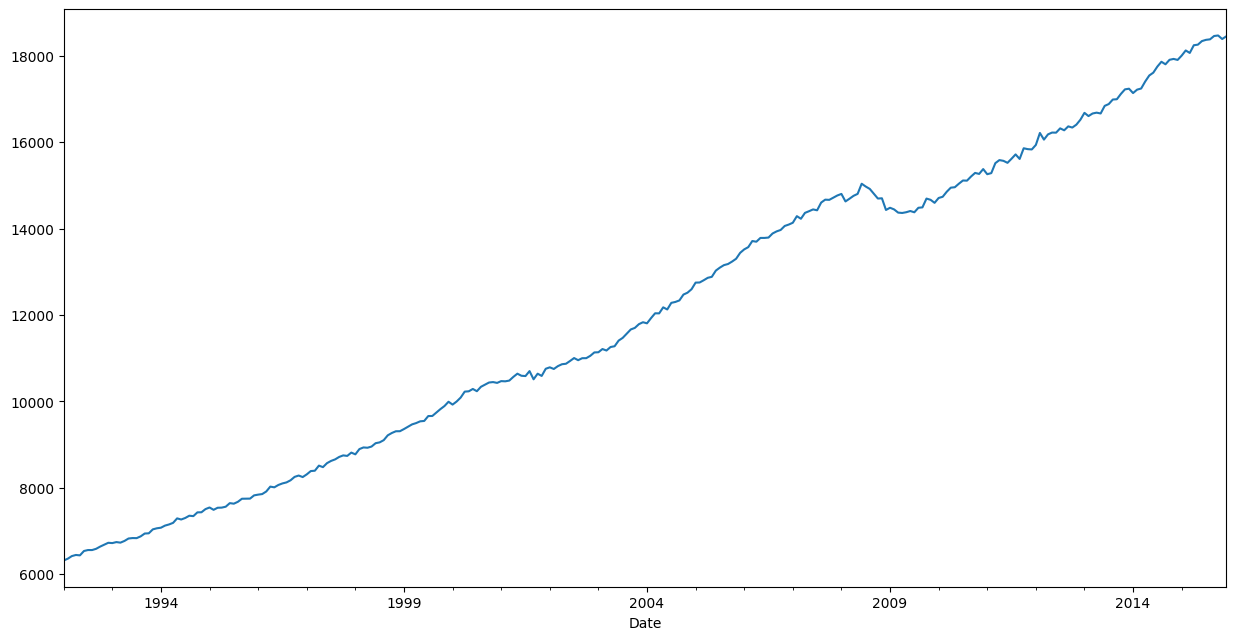

In [10]:
# visualize the dataframe
gdp_df['Monthly Nominal GDP Index']. plot(figsize=(15, 7.5))

<Axes: xlabel='Date'>

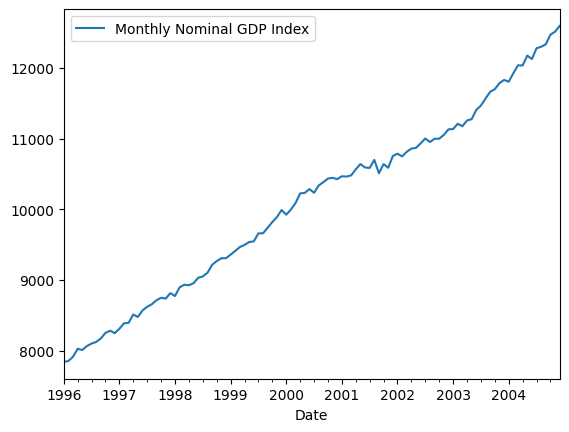

In [11]:
# visualize GDP from 1992 to 10 years after 9/11
gdp_df.loc['1996':'2004', ['Monthly Nominal GDP Index']].plot()


In [12]:
# reset index for gdp_df to prepare for prophet
# use 'Monthly Nominal GDP Index' to account for inflation and deflation
gdp_rs_index_df = gdp_df.reset_index()
gdp_rs_index_df = gdp_rs_index_df[['Date', 'Monthly Nominal GDP Index']]
gdp_rs_index_df

,Date,Monthly Nominal GDP Index
0,1992-01-01,6315.718
1,1992-02-01,6356.508
2,1992-03-01,6417.080
3,1992-04-01,6443.260
4,1992-05-01,6433.800
...,...,...
283,2015-08-01,18379.862
284,2015-09-01,18456.886
285,2015-10-01,18469.416
286,2015-11-01,18387.708


In [13]:
# slice gdp_rs_index_df up until 2001-09
# rename columns to 'ds', 'y'
nine_eleven_gdp_df = gdp_rs_index_df.loc[gdp_rs_index_df['Date'] < '2001-09']
nine_eleven_gdp_df = nine_eleven_gdp_df.rename(columns={'Date': 'ds', 'Monthly Nominal GDP Index': 'y'})
nine_eleven_gdp_df

,ds,y
0,1992-01-01,6315.718
1,1992-02-01,6356.508
2,1992-03-01,6417.080
3,1992-04-01,6443.260
4,1992-05-01,6433.800
...,...,...
111,2001-04-01,10565.350
112,2001-05-01,10639.985
113,2001-06-01,10591.666
114,2001-07-01,10585.078


In [14]:
# # Call the Prophet function, store as an object
model_9_11 = Prophet()
model_9_11

In [15]:
# fit the Prophet model
model_9_11.fit(nine_eleven_gdp_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp94ay7d03/kd4puipt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp94ay7d03/gsgp_poy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16521', 'data', 'file=/tmp/tmp94ay7d03/kd4puipt.json', 'init=/tmp/tmp94ay7d03/gsgp_poy.json', 'output', 'file=/tmp/tmp94ay7d03/prophet_modelrqna_6kv/prophet_model-20241002182311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [16]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 36 months (3 years)
future_9_11 = model_9_11.make_future_dataframe(periods=36, freq='M')

# View the last five rows of the predictions
future_9_11.tail()



/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


,ds
147,2004-03-31
148,2004-04-30
149,2004-05-31
150,2004-06-30
151,2004-07-31


In [17]:
# Make the predictions for the trend data using the future_trends DataFrame
forecast_9_11 = model_9_11.predict(future_9_11)

# Display the first five rows of the forecast DataFrame
forecast_9_11.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1992-01-01,6350.187340,6287.984779,6388.460943,6350.187340,6350.187340,-12.266773,-12.266773,-12.266773,-12.266773,-12.266773,-12.266773,0.0,0.0,0.0,6337.920566
1,1992-02-01,6379.768599,6319.135929,6419.249464,6379.768599,6379.768599,-10.993908,-10.993908,-10.993908,-10.993908,-10.993908,-10.993908,0.0,0.0,0.0,6368.774691
2,1992-03-01,6407.441390,6336.504104,6438.273241,6407.441390,6407.441390,-17.464556,-17.464556,-17.464556,-17.464556,-17.464556,-17.464556,0.0,0.0,0.0,6389.976834
3,1992-04-01,6437.022650,6419.939391,6523.678834,6437.022650,6437.022650,34.229494,34.229494,34.229494,34.229494,34.229494,34.229494,0.0,0.0,0.0,6471.252143
4,1992-05-01,6465.649675,6415.483655,6520.355461,6465.649675,6465.649675,-0.975568,-0.975568,-0.975568,-0.975568,-0.975568,-0.975568,0.0,0.0,0.0,6464.674107


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


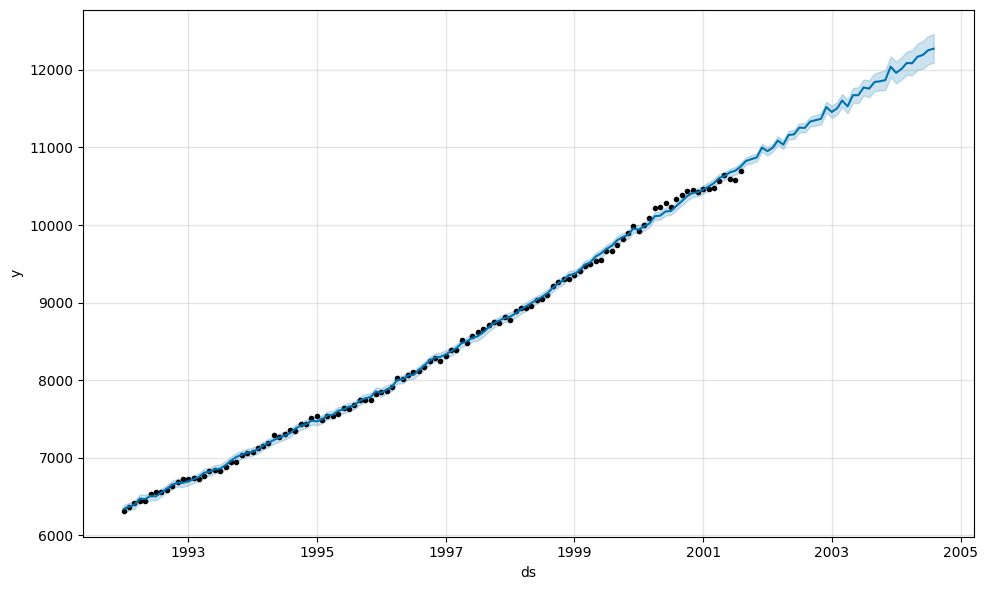

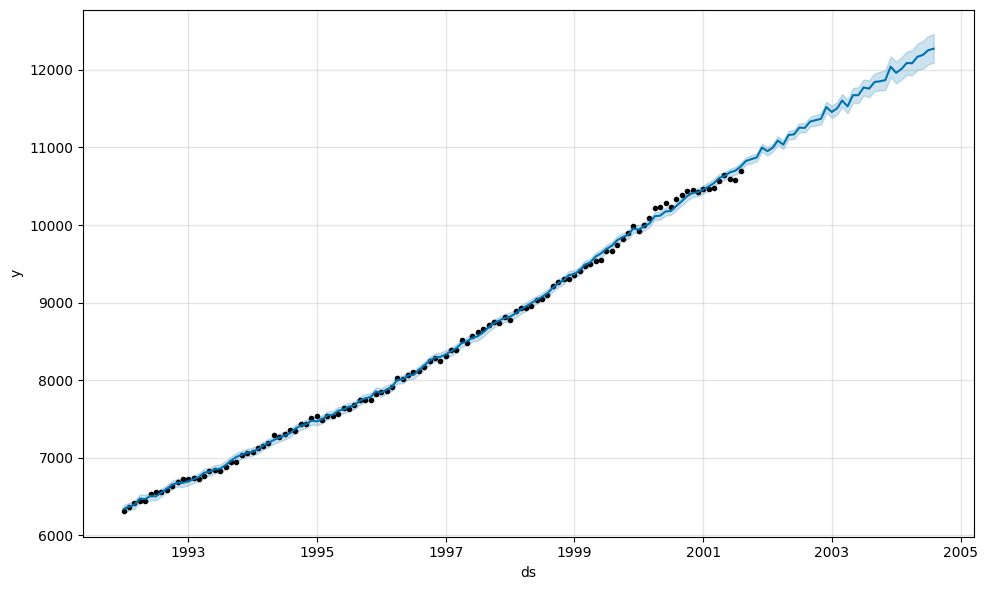

In [18]:
# Plot the Prophet predictions for the 9/11 trends data
model_9_11.plot(forecast_9_11)

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

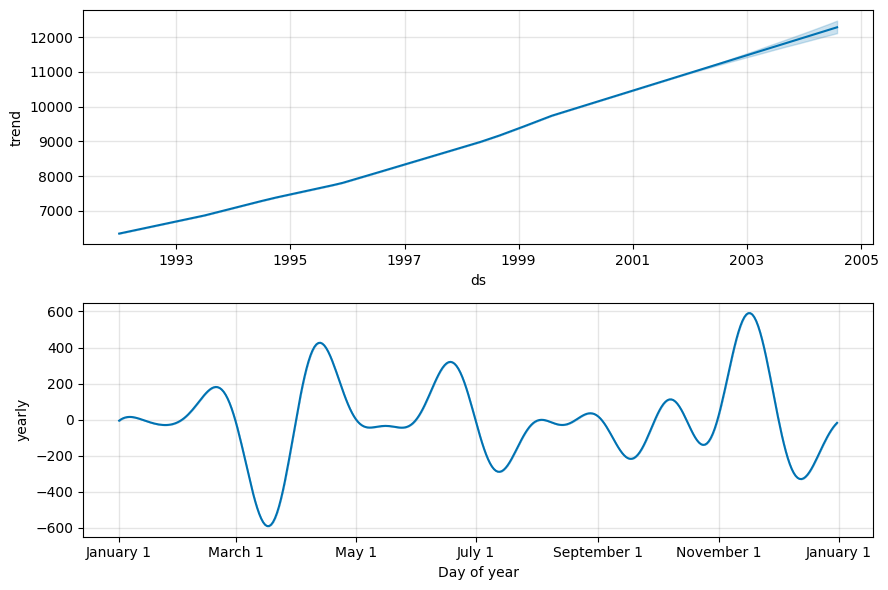

In [19]:
# Use the plot_components function to visualize the forecast results
figure = model_9_11.plot_components(forecast_9_11)

<Axes: xlabel='ds'>

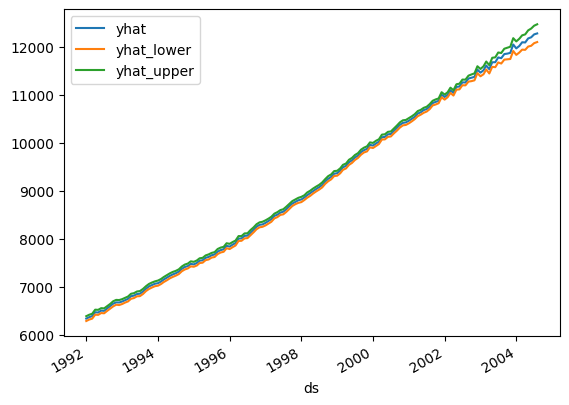

In [20]:
# set 'ds' as index
# From the `forecast_9_11` DataFrame, plot to visualize
# the yhat, yhat_lower, and yhat_upper columns
forecast_9_11 = forecast_9_11.set_index('ds')
forecast_9_11[['yhat', 'yhat_lower', 'yhat_upper']].plot()

<Axes: xlabel='Date'>

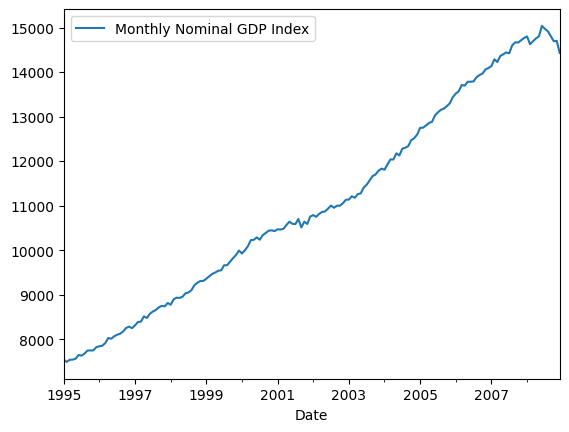

In [21]:
# create a df for hurricane Katrina
gdp_df.loc['1995':'2008', ['Monthly Nominal GDP Index']].plot()


In [22]:
# slice gdp_rs_index_df from 1992 to 2005-08
# rename columns to 'ds', 'y'
katrina_gdp_df = gdp_rs_index_df.loc[gdp_rs_index_df['Date'] < '2005-08']
katrina_gdp_df = katrina_gdp_df.rename(columns={'Date': 'ds', 'Monthly Nominal GDP Index': 'y'}).reset_index(drop=True)
katrina_gdp_df.head()

,ds,y
0,1992-01-01,6315.718
1,1992-02-01,6356.508
2,1992-03-01,6417.080
3,1992-04-01,6443.260
4,1992-05-01,6433.800


In [23]:
# # Call the Prophet function, store as an object
model_katrina = Prophet()
model_katrina

In [24]:
# # fit the Prophet model
model_katrina.fit(katrina_gdp_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp94ay7d03/3560eojr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp94ay7d03/iqazrj45.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8710', 'data', 'file=/tmp/tmp94ay7d03/3560eojr.json', 'init=/tmp/tmp94ay7d03/iqazrj45.json', 'output', 'file=/tmp/tmp94ay7d03/prophet_modelz44evngd/prophet_model-20241002182317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [25]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 36 months (3 years)
future_katrina = model_katrina.make_future_dataframe(periods=36, freq='M')

# View the last five rows of the predictions
future_katrina.tail()



/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


,ds
194,2008-02-29
195,2008-03-31
196,2008-04-30
197,2008-05-31
198,2008-06-30


In [26]:
# Make the predictions for the trend data using the future_trends DataFrame
forecast_katrina = model_katrina.predict(future_katrina)

# Display the first five rows of the forecast DataFrame
forecast_katrina.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1992-01-01,6352.562089,6274.265170,6377.438332,6352.562089,6352.562089,-25.583609,-25.583609,-25.583609,-25.583609,-25.583609,-25.583609,0.0,0.0,0.0,6326.978480
1,1992-02-01,6382.062369,6319.570142,6422.372545,6382.062369,6382.062369,-10.890055,-10.890055,-10.890055,-10.890055,-10.890055,-10.890055,0.0,0.0,0.0,6371.172313
2,1992-03-01,6409.659405,6337.696131,6435.200957,6409.659405,6409.659405,-20.406126,-20.406126,-20.406126,-20.406126,-20.406126,-20.406126,0.0,0.0,0.0,6389.253279
3,1992-04-01,6439.159685,6404.452767,6501.684197,6439.159685,6439.159685,12.437270,12.437270,12.437270,12.437270,12.437270,12.437270,0.0,0.0,0.0,6451.596955
4,1992-05-01,6467.708342,6423.081168,6523.668038,6467.708342,6467.708342,6.619801,6.619801,6.619801,6.619801,6.619801,6.619801,0.0,0.0,0.0,6474.328143


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


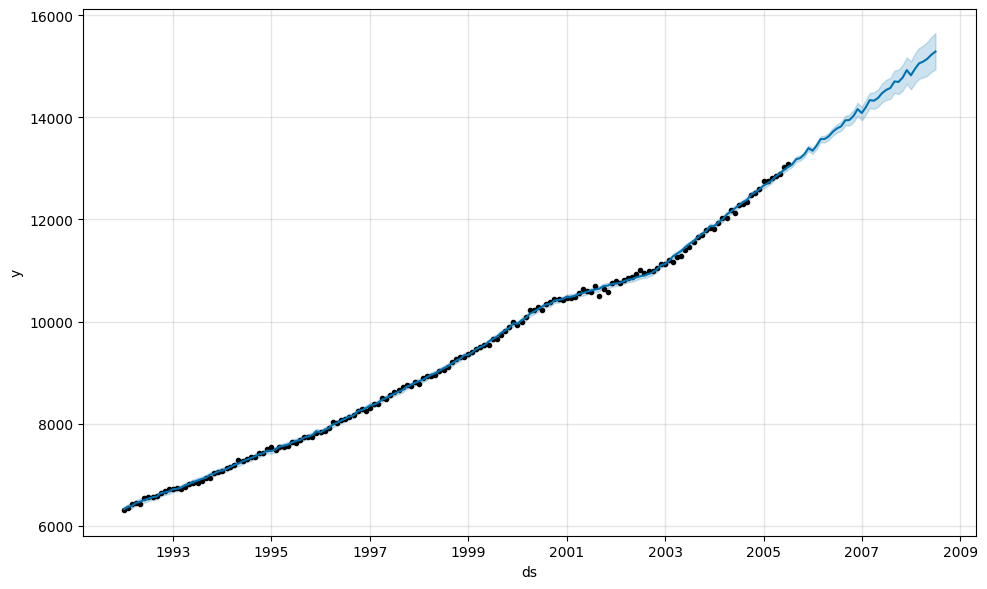

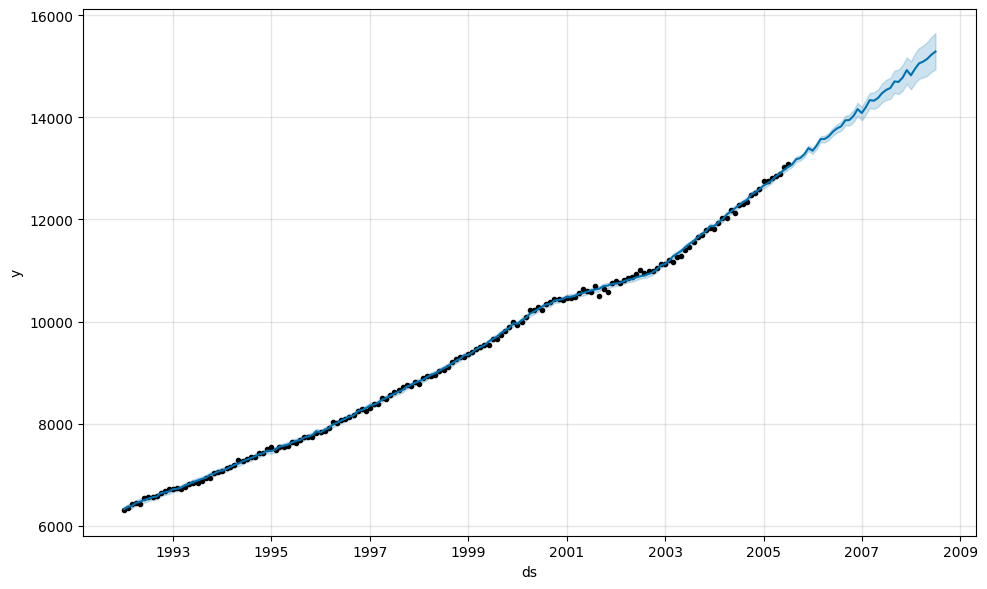

In [27]:
# Plot the Prophet predictions for the 9/11 trends data
model_katrina.plot(forecast_katrina)


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

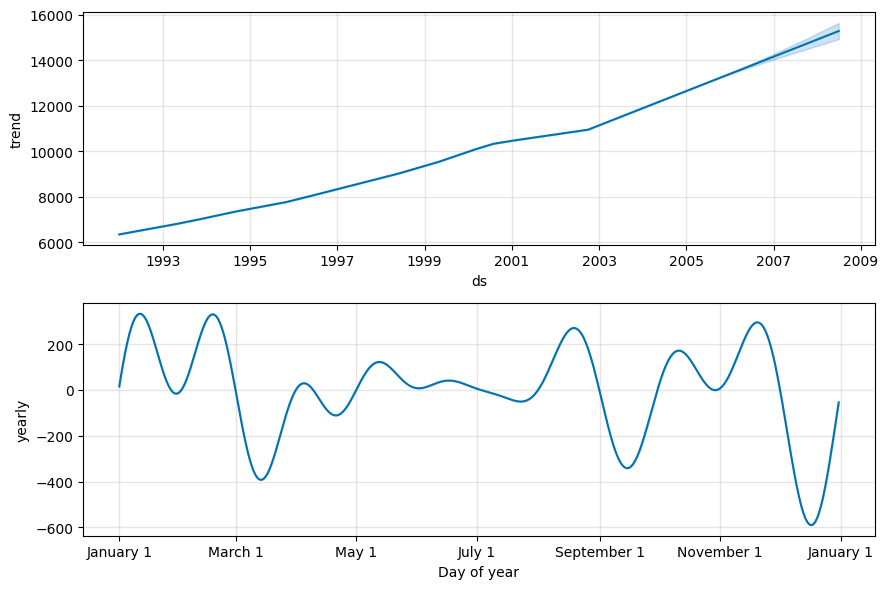

In [28]:
# Use the plot_components function to visualize the forecast results
figure = model_katrina.plot_components(forecast_katrina)

<Axes: xlabel='ds'>

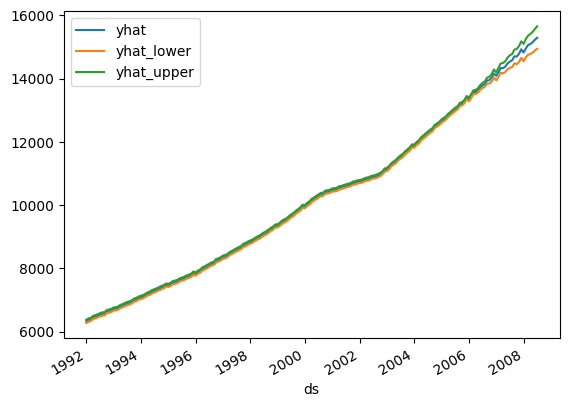

In [29]:
# set 'ds' as index
# From the `forecast_katrina` DataFrame, plot to visualize
# the yhat, yhat_lower, and yhat_upper columns
forecast_katrina = forecast_katrina.set_index('ds')
forecast_katrina[['yhat', 'yhat_lower', 'yhat_upper']].plot()

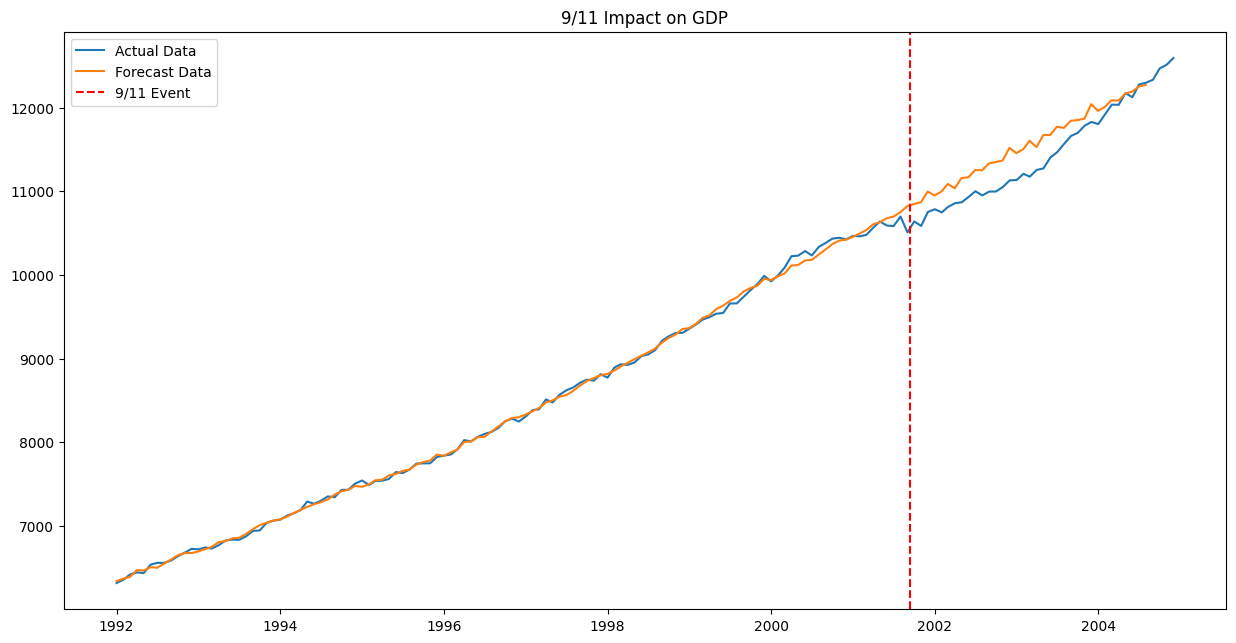

In [32]:
# Create a figure with a specified size
plt.figure(figsize=(15, 7.5))


# create nine_eleven_actual_gdp_df which is the gdp_df sliced from 1992 to 2004
# plot nine_eleven_actual_gdp_df and the forecast in the same plot

nine_eleven_actual_gdp_df= gdp_df.loc['1992':'2004']
plt.plot(nine_eleven_actual_gdp_df.index, nine_eleven_actual_gdp_df['Monthly Nominal GDP Index'], label = 'Actual Data')
plt.plot(forecast_9_11.index, forecast_9_11['yhat'], label= 'Forecast Data')
plt.title('9/11 Impact on GDP')


# make the vertical event line for 2001-09-11

event_date = pd.to_datetime('2001-09-11')
plt.axvline(x=event_date, color='red', linestyle='--', label='9/11 Event')
plt.legend()
plt.show()


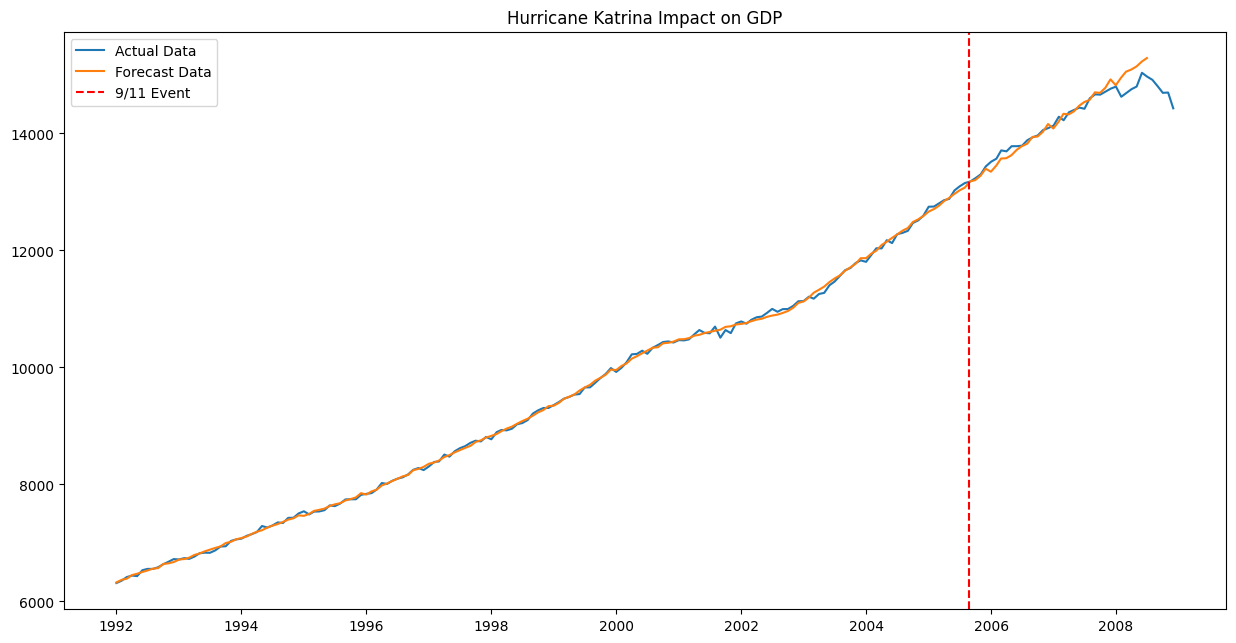

In [31]:
# Create a figure with a specified size
plt.figure(figsize=(15, 7.5))

# create katrina_actual_gdp_df which is the gdp_df sliced from 1992 to 2008
# plot katrina_actual_gdp_df and the forecast in the same plot
# create a legend
katrina_actual_gdp_df= gdp_df.loc['1992':'2008']
plt.plot(katrina_actual_gdp_df.index, katrina_actual_gdp_df['Monthly Nominal GDP Index'], label = 'Actual Data')
plt.plot(forecast_katrina.index, forecast_katrina['yhat'], label= 'Forecast Data')
plt.title('Hurricane Katrina Impact on GDP')


# make the vertical event line for 2001-09-11
event_date = pd.to_datetime('2005-08-23')
plt.axvline(x=event_date, color='red', linestyle='--', label='9/11 Event')

plt.legend()
plt.show()

In [33]:
# export gdp_df as csv
# export forecast_9_11 as csv
# export forecast_katrina as csv
gdp_df.to_csv('gdp_cleaned.csv')
forecast_9_11.to_csv('forecast_9_11_gdp.csv')
forecast_katrina.to_csv('forecast_katrina_gdp.csv')